# Sparkland test task
Completed by Aleksandra Bukreeva (sashabukreeva20@gmail.com)

In [1]:
import numpy as np         # matrix & maths
import pandas as pd        # panel data
from scipy import stats    # statistics for A/B testing

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for candlesticks
import mplfinance as mpf   
import plotly.graph_objects as go
import plotly.io as pio

# graphs style
plt.style.use('ggplot')    
# interactive graphs
pio.renderers.default = 'notebook'  

### 1. Data exploration

#### 1.1. Load the dataset into a Pandas DataFrame (or use any other data manipulation libraries in Python you want)

In [2]:
# dataset extraction
data = pd.read_csv('orders.csv', sep = ',')
data.head()

,id,timestamp,market,pair,side,quantity,price,order_type,execution_time
0,1,1733000400000165,BINANCE,ETH_USDT,ASK,0.316,368.4531,Limit,7.280
1,2,1733000400000970,HUOBI,ADA_USDT,BID,0.545,188.0561,Market,1.798
2,3,1733000400001831,KRAKEN,ADA_USDT,BID,0.768,552.3179,Market,9.086
3,4,1733000400001953,KRAKEN,LTC_USDT,BID,0.214,975.9048,Limit,2.879
4,5,1733000400002031,HUOBI,LTC_USDT,ASK,0.934,734.8854,Market,0.444


In [3]:
print(data.shape)

(42900318, 9)


In [4]:
# asessing columns' types to understand how to work with each one
print(data.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42900318 entries, 0 to 42900317
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   timestamp       int64  
 2   market          object 
 3   pair            object 
 4   side            object 
 5   quantity        float64
 6   price           float64
 7   order_type      object 
 8   execution_time  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.9+ GB
None


In [5]:
# comparing count of ids to number of rows in dataset to check it for duplicates
print(data.nunique()) 

id                42900318
timestamp         42857298
market                   3
pair                     5
side                     2
quantity              1000
price              9861469
order_type               2
execution_time       10219
dtype: int64


In [6]:
# basic understanding of data
print(data.describe())

                 id     timestamp      quantity         price  execution_time
count  4.290032e+07  4.290032e+07  4.290032e+07  4.290032e+07    4.290032e+07
mean   2.145016e+07  1.733043e+15  5.004428e-01  5.000448e+02    5.068667e+00
std    1.238426e+07  2.493128e+10  2.883960e-01  2.886483e+02    5.900863e+00
min    1.000000e+00  1.733000e+15  1.000000e-03  1.000000e-01    1.000000e-01
25%    1.072508e+07  1.733022e+15  2.510000e-01  2.500447e+02    2.576000e+00
50%    2.145016e+07  1.733043e+15  5.000000e-01  5.000942e+02    5.052000e+00
75%    3.217524e+07  1.733065e+15  7.500000e-01  7.500758e+02    7.528000e+00
max    4.290032e+07  1.733087e+15  1.000000e+00  1.000000e+03    1.996670e+03


In [7]:
# checking nulls in each column
data.isnull().sum()

id                0
timestamp         0
market            0
pair              0
side              0
quantity          0
price             0
order_type        0
execution_time    0
dtype: int64

#### 1.2. Find data loss periods if any

1. Convert timestamp into datetime format with microseconds
2. Visually assess datetime density plot.
3. Find data loss periods. 

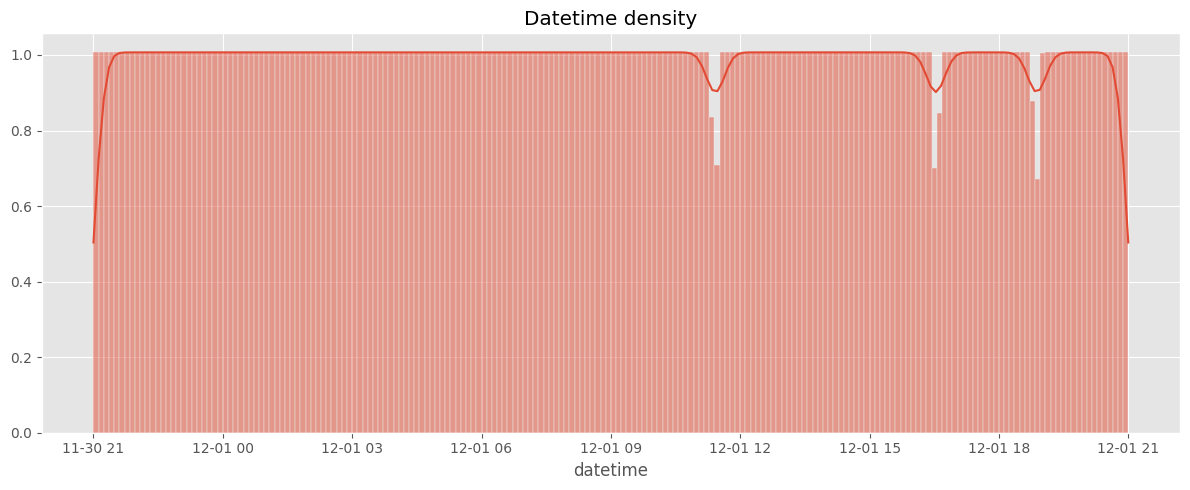

In [8]:
# convert timestamp into datetime format with microseconds
data['datetime'] = pd.to_datetime(data['timestamp'], unit='us')

# density plot
plt.figure(figsize=(12, 5))

sns.histplot(data['datetime'], stat='density', bins=200, kde=True)

plt.ylabel('')
plt.title('Datetime density')

plt.tight_layout()

In [9]:
# sorting by timestamp
data = data.sort_values('datetime')

# calculating time gaps 
data['time_diff'] = data['datetime'].diff()

# gaps overview
print('Average time between trades:', data['time_diff'].mean())
print('Median time between trades:', data['time_diff'].median())

Average time between trades: 0 days 00:00:00.002013953
Median time between trades: 0 days 00:00:00.000501


In [10]:
# from previous output we can see that the median gap between trades is ~0.5ms.
# let's set the threshold of 1ms to find potential data loss periods  

# setting the threshold of 1ms
threshold = pd.Timedelta('1ms')

loss_periods = data[data['time_diff'] > threshold]

# these are orders with gap between trades > 1ms
print(loss_periods[['datetime', 'time_diff']])

                           datetime              time_diff
500      2024-11-30 21:00:01.000076 0 days 00:00:00.758939
1000     2024-11-30 21:00:02.000448 0 days 00:00:00.754867
1500     2024-11-30 21:00:03.000649 0 days 00:00:00.756023
2000     2024-11-30 21:00:04.000901 0 days 00:00:00.751111
2500     2024-11-30 21:00:05.000185 0 days 00:00:00.756096
...                             ...                    ...
42897818 2024-12-01 20:59:55.000638 0 days 00:00:00.746006
42898318 2024-12-01 20:59:56.000790 0 days 00:00:00.755309
42898818 2024-12-01 20:59:57.000624 0 days 00:00:00.746343
42899318 2024-12-01 20:59:58.000498 0 days 00:00:00.752651
42899818 2024-12-01 20:59:59.000361 0 days 00:00:00.744874

[86399 rows x 2 columns]


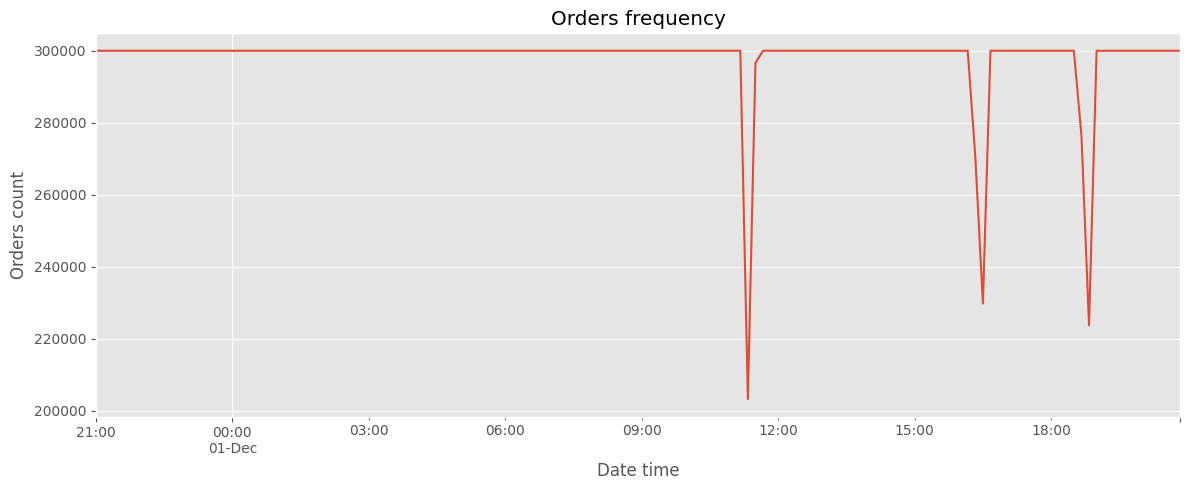

In [12]:
trades_per_10min = data.set_index('datetime').resample('10min')['id'].count()

# Рисуем гистограмму
plt.figure(figsize=(12,5))
trades_per_10min.plot(kind='line')

plt.ylabel('Orders count')
plt.xlabel('Date time')
plt.title('Orders frequency')
plt.tight_layout()

**Insights**:
- The median gap between trades is `~0.5ms`, while the mean is 2ms => there are outliers (huge gaps between orders).
- From the visual analysis, we can see that on 1, Dec there were several periods with a reduced number of transactions (around 11:00, 16:30 and 18:30)

### 2. Statistical analysis

#### 2.1. Identify any outliers in trade quantity or execution times

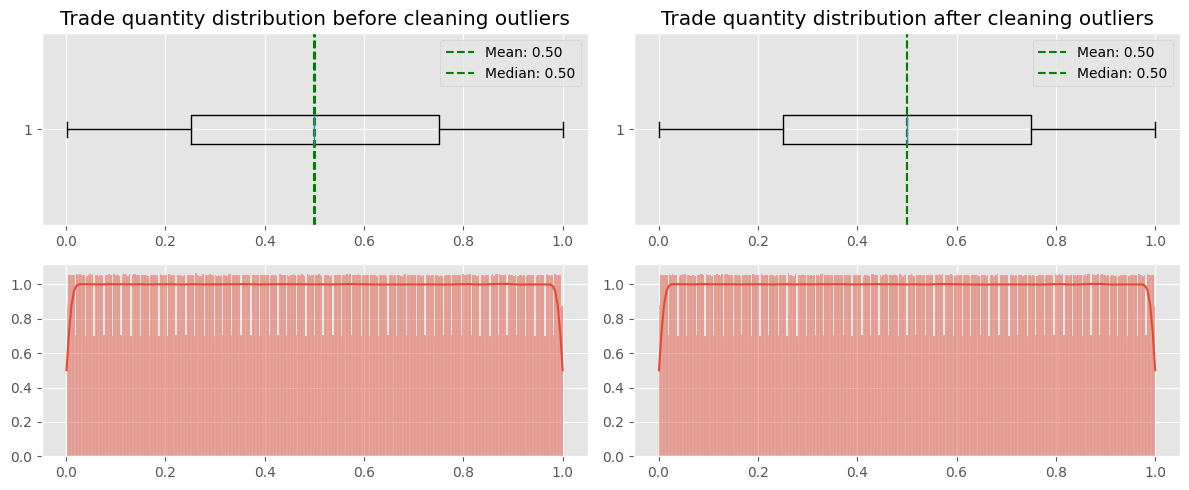

In [13]:
# visual outliers analysis in trade quantity

# before cleaning outliers

# mean, median
avg_before = data['quantity'].mean()
median_before = data['quantity'].quantile(0.5)

plt.figure(figsize=(12, 5))

plt.subplot(221)
plt.boxplot(data['quantity'], vert = False)

# showing statistics 
plt.axvline(avg_before, color='green', linestyle='--', label=f'Mean: {avg_before:.2f}')
plt.axvline(median_before, color='green', linestyle='--', label=f'Median: {median_before:.2f}')
plt.title('Trade quantity distribution before cleaning outliers')
plt.ylabel('')
plt.xlabel('')

plt.legend()

plt.subplot(223)
sns.histplot(data['quantity'], kde = True, stat = 'density')
plt.ylabel('')
plt.xlabel('')

# after cleaning outliers
# using inerqantile range method
Q1 = data['quantity'].quantile(0.25)
Q3 = data['quantity'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

orders_no_outliers = data[(data['quantity'] >= lower) & (data['quantity'] <= upper)]

# mean, median
avg_after = orders_no_outliers['quantity'].mean()
median_after = orders_no_outliers['quantity'].quantile(0.5)


plt.subplot(222)
plt.boxplot(orders_no_outliers['quantity'], vert = False)
plt.axvline(avg_after, color='green', linestyle='--', label=f'Mean: {avg_after:.2f}')
plt.axvline(median_after, color='green', linestyle='--', label=f'Median: {median_after:.2f}')
plt.title('Trade quantity distribution after cleaning outliers')
plt.ylabel('')
plt.xlabel('')

plt.legend()

plt.subplot(224)
sns.histplot(orders_no_outliers['quantity'], kde = True, stat = 'density')
plt.ylabel('')
plt.xlabel('')

plt.tight_layout()

In [14]:
print(data.shape, orders_no_outliers.shape)

(42900318, 11) (42900318, 11)


**Insights**:
- Number of rows 'before/after' is the same.
- we haven't removed any outliers => we can use the 'data' dataset in the outliers analysis of execution_time.

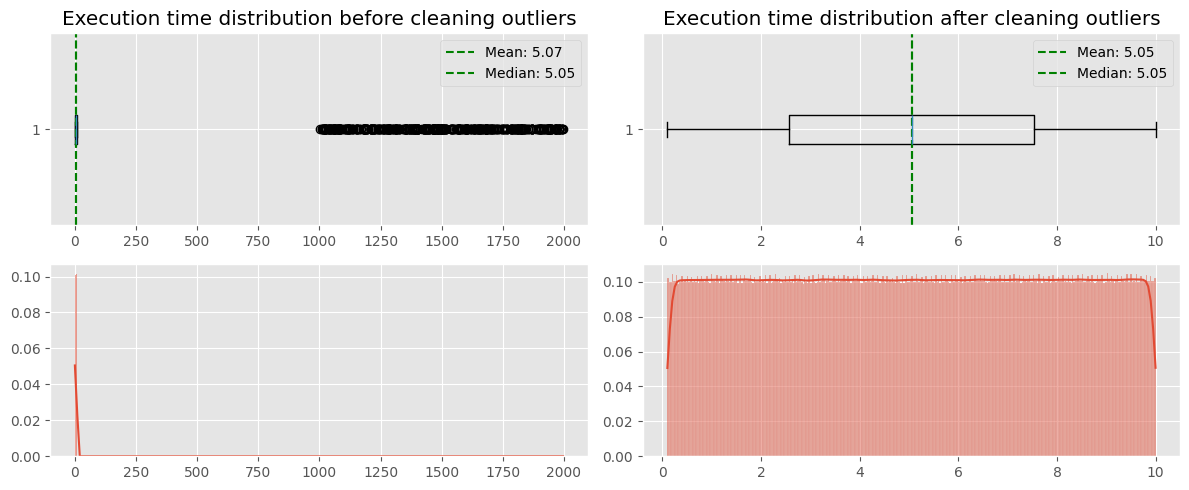

In [15]:
# visual outliers analysis in execution_time

# mean, median
avg_before = data['execution_time'].mean()
median_before = data['execution_time'].quantile(0.5)

# before cleaning outliers
plt.figure(figsize=(12, 5))

plt.subplot(221)
plt.boxplot(data['execution_time'], vert = False)
# showing statistics 
plt.axvline(avg_before, color='green', linestyle='--', label=f'Mean: {avg_before:.2f}')
plt.axvline(median_before, color='green', linestyle='--', label=f'Median: {median_before:.2f}')
plt.title('Execution time distribution before cleaning outliers')
plt.legend()


plt.subplot(223)
sns.histplot(data['execution_time'], kde = True, stat = 'density')
plt.ylabel('')
plt.xlabel('')

# after cleaning outliers
# using inerqantile range method
Q1 = data['execution_time'].quantile(0.25)
Q3 = data['execution_time'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

orders_cleaned = data[(data['execution_time'] >= lower) & (data['execution_time'] <= upper)]

# mean, median
avg_after = orders_cleaned['execution_time'].mean()
median_after = orders_cleaned['execution_time'].quantile(0.5)


plt.subplot(222)
plt.boxplot(orders_cleaned['execution_time'], vert = False)
plt.axvline(avg_after, color='green', linestyle='--', label=f'Mean: {avg_after:.2f}')
plt.axvline(median_after, color='green', linestyle='--', label=f'Median: {median_after:.2f}')
plt.title('Execution time distribution after cleaning outliers')
plt.legend()


plt.subplot(224)
sns.histplot(orders_cleaned['execution_time'], kde = True, stat = 'density')
plt.ylabel('')
plt.xlabel('')

plt.tight_layout()

In [16]:
print(data.shape, orders_cleaned.shape)

(42900318, 11) (42899818, 11)


**Insights**:
- Number of rows 'before/after' is NOT the same. `42 900 318 vs 42 899 818` => we've removed 500 outliers.
- We also can notice the difference between 'before/after' mean values. `5.07 vs 5.05`

#### 2.2. Compute the average trade quantity and build a distribution of execution time per market (take care of outliers)

0.5004428456917266
BINANCE: 0.5004
HUOBI: 0.5005
KRAKEN: 0.5005


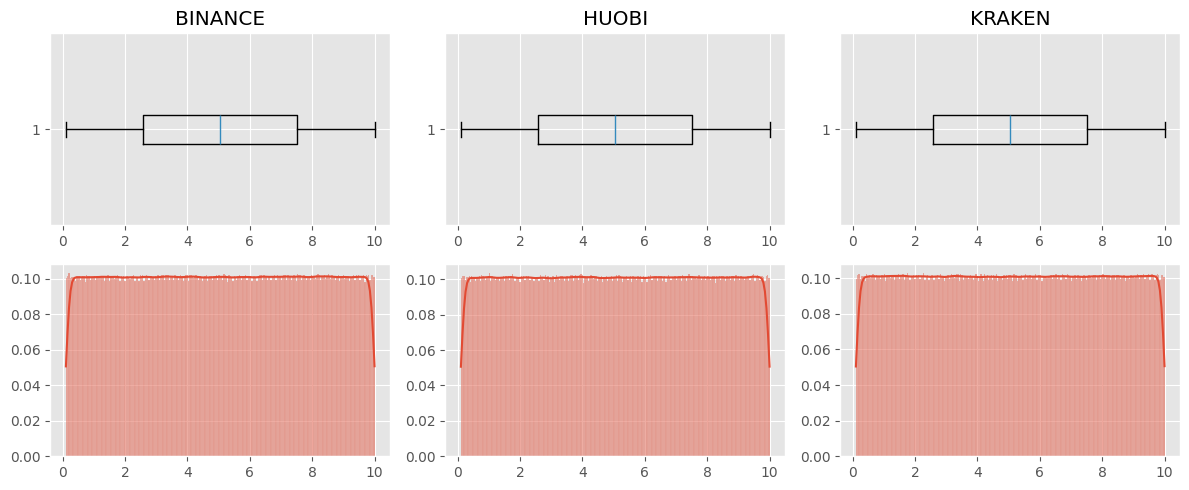

In [17]:
avg_trade_quantity_general = data['quantity'].mean()

print(avg_trade_quantity_general)

# building boxplots for each market 
# removed outliers in 2.1. step => using orders_cleaned dataset

# unique markets from orders_cleaned
markets_list = orders_cleaned['market'].unique().tolist()

# average trade quantity 
for market in markets_list:
    avg_qty = orders_cleaned[orders_cleaned['market'] == market]['quantity'].mean()
    print(f'{market}: {avg_qty:.4f}')


# new dataframes for each unique market from orders_cleaned
dfs_by_market = {}

for market in markets_list:
    # filtering by market
    dfs_by_market[market] = orders_cleaned[orders_cleaned['market'] == market]


markets_сount = len(markets_list)

# 2 graphs for each market: density distribution + boxplot 
total_plots = markets_сount * 2

# number of cols and rows for graphs matrix
n_cols = 2  
n_rows = markets_сount  

plt.figure(figsize=(12, 5))

# boxplots
for i, market in enumerate(markets_list):
    df = dfs_by_market[market]
    plt.subplot(2, markets_сount, i+1)  # 2 ряда, n_markets столбцов
    plt.boxplot(df['execution_time'], vert = False)
    plt.title(f'{market}')
    plt.xlabel('')  
    plt.ylabel('') 

# density distributions
for i, market in enumerate(markets_list):
    df = dfs_by_market[market]
    plt.subplot(2, markets_сount, markets_сount + i + 1) 
    sns.histplot(df['execution_time'], kde = True, stat = 'density')
    plt.xlabel('')  
    plt.ylabel('')
    
plt.tight_layout()

(array([1, 2, 3]),
 [Text(1, 0, 'BINANCE'), Text(2, 0, 'HUOBI'), Text(3, 0, 'KRAKEN')])

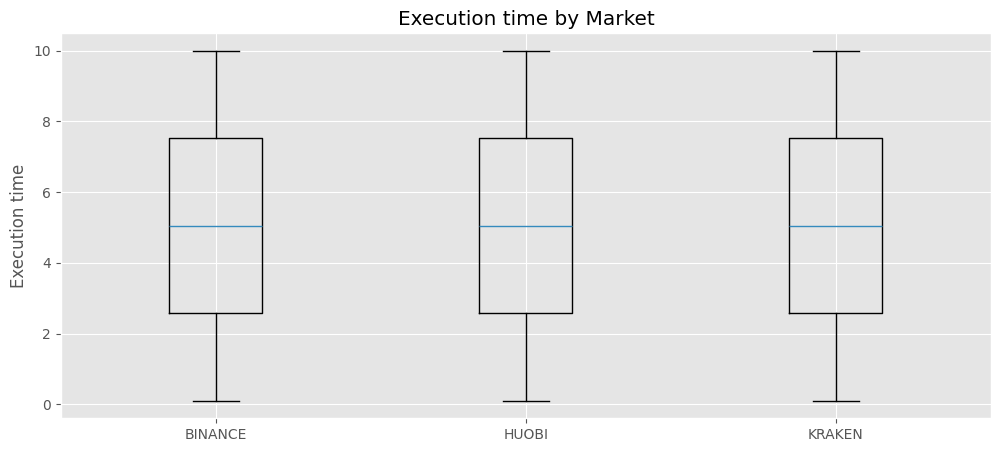

In [18]:
# dfs execution_time per market
data_to_plot = [dfs_by_market[market]['execution_time'] for market in dfs_by_market.keys()]
labels = list(dfs_by_market.keys())

plt.figure(figsize=(12, 5))
plt.boxplot(data_to_plot, vert = True, tick_labels = labels)
plt.title('Execution time by Market')
plt.ylabel('Execution time')
plt.xticks(rotation = 0) 

**Insights**:
1. Average trade quantity in general – `0.5004`. Per market:
- BINANCE: `0.5004`
- HUOBI: `0.5005`
- KRAKEN: `0.5005`
2. All of the markets in sample shows similar execution time.
3. Additionally assessed boxplots vertically that all markets have the same distribution of execution_time.

#### 2.3. Process trade data to aggregate 10-minute OHLC (Open, High, Low, Close) candlesticks grouped by trading pair and market. Include the total traded volume for each interval alongside OHLC values. Visualisation is optional

In [19]:
# Open: the price when the trading interval began. 
# High: the highest price the asset reached during that interval. 
# Low: the lowest price the asset reached during that interval. 
# Close: the final price at the end of the interval. 

# rounding into 10min interval
orders_cleaned = orders_cleaned.copy() 
orders_cleaned.loc[:, 'datetime_10min'] = orders_cleaned['datetime'].dt.floor('10min')

# grouping by market, pair and interval
ohlc_df = orders_cleaned.groupby(['market', 'pair', 'datetime_10min']).agg(
    open=('price', 'first'),
    high=('price', 'max'),
    low=('price', 'min'),
    close=('price', 'last'),
    volume=('quantity', 'sum')
).reset_index()

# checking the final dataset
ohlc_df.head()

,market,pair,datetime_10min,open,high,low,close,volume
0,BINANCE,ADA_USDT,2024-11-30 21:00:00,612.8891,999.8709,0.1008,172.0791,9948.105
1,BINANCE,ADA_USDT,2024-11-30 21:10:00,255.8810,999.9727,0.2025,221.2445,9962.360
2,BINANCE,ADA_USDT,2024-11-30 21:20:00,24.4540,999.9357,0.1565,37.4318,10143.585
3,BINANCE,ADA_USDT,2024-11-30 21:30:00,711.2671,999.9468,0.1346,56.1721,9980.803
4,BINANCE,ADA_USDT,2024-11-30 21:40:00,725.5974,999.9711,0.1299,914.2780,10047.850


In [23]:
fig = go.Figure(data=go.Candlestick(x=ohlc_df['datetime_10min'],
                                     open=ohlc_df['open'],
                                     high=ohlc_df['high'],
                                     low=ohlc_df['low'],
                                     close=ohlc_df['close']))
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

### 3. A/B testing
We have a hypothesis that "Market orders result in faster executions compared to limit orders"
- Please conduct an A/B test comparing two strategies: Strategy A uses market orders, while Strategy B uses limit orders.
- Perform an analysis using statistical tests to compare the median execution times between market orders and limit orders.
- Calculate the p-value and draw conclusions on whether the observed diﬀerences are statistically significant.

#### Designing the test
- `H0`: **Market orders have the same executions as limit orders**.
- `H1`: **Market orders result in faster executions compared to limit orders**. 

group А = market orders \
group В = limit orders

- `H0`: median(execution_time on market orders) = median(execution_time on limit orders) 
- `H1`: median(execution_time on market orders) > median(execution_time on limit orders)

**Steps**:
1. Check if execution_time is distributed normally.
2. Based on result after 1. choose statistical criterion.
3. Perform A/B test, calculate p-value.
4. Draw conclusions on whether the observed diﬀerences are statistically significant.

In [21]:
# groups A and B
time_market = data['execution_time'][(data['order_type'] == 'Market')]
time_limit = data['execution_time'][(data['order_type'] == 'Limit')]

# hypothesis about normal distribution
stat_market = stats.normaltest(time_market) 
print(stat_market)

alpha = 0.05 
if stat_market[1] > alpha:
    print('Distribution time_market is normal.')
else:
    print('Distribution time_market is NOT normal.')


stat_limit = stats.normaltest(time_limit) 
print(stat_limit)

if stat_limit[1] > alpha:
    print('Distribution time_limit is normal.')
else:
    print('Distribution time_limit is NOT normal.')

NormaltestResult(statistic=np.float64(105872544.21527046), pvalue=np.float64(0.0))
Distribution time_market is NOT normal.
NormaltestResult(statistic=np.float64(105883702.96095425), pvalue=np.float64(0.0))
Distribution time_limit is NOT normal.


- Both A and B distributions are NOT normal.
- For median values comparison I'll use [Mood's median test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html).

In [22]:
statistics = stats.median_test(time_market, time_limit)

print(f'p-value = {statistics[1]:.3f}')

if statistics[1] < 0.05:
    print('Medians difference is statistically significant => rejecting the null hypothesis H0.')
else:
    print('Medians difference is NOT statistically significant => NOT rejecting the null hypothesis H0.')

p-value = 0.069
Medians difference is NOT statistically significant => NOT rejecting the null hypothesis H0.


**Insights**:
- In Mood's median test we've got `p-value = 0.069 (> 0.05)`
- We did not find a statistically significant difference in the median execution time between Market and Limit orders with alpha = 0.05.
- => **Market orders have the same executions as limit orders.**